In [1]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime



In [2]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/GBPJPY_Daily.csv')
print(df.head()) #7 columns, including the Date. 



        Date        Open        High         Low       Close   Adj Close
0  12/1/2003  189.330002  189.660004  187.740005  187.630005  187.630005
1  12/2/2003  187.669998  188.809998  187.559998  188.009995  188.009995
2  12/3/2003  188.020004  188.240005  186.490005  187.089996  187.089996
3  12/4/2003  187.029999  187.029999  185.899994  186.220001  186.220001
4  12/5/2003  186.190002  186.740005  185.830002  185.880005  185.880005


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 



4640   2021-09-13
4641   2021-09-14
4642   2021-09-15
4643   2021-09-16
4644   2021-09-17
4645   2021-09-20
4646   2021-09-21
4647   2021-09-22
4648   2021-09-23
4649   2021-09-24
4650   2021-09-27
4651   2021-09-28
4652   2021-09-29
4653   2021-09-30
4654   2021-10-01
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']



['Open', 'High', 'Low', 'Close', 'Adj Close']


In [5]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))



trainX shape == (4641, 14, 5).
trainY shape == (4641, 1).


In [6]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
261/261 [==============================] - 5s 13ms/step - loss: nan - val_loss: nan
Epoch 2/5
261/261 [==============================] - 3s 11ms/step - loss: nan - val_loss: nan
Epoch 3/5
261/261 [==============================] - 3s 11ms/step - loss: nan - val_loss: nan
Epoch 4/5
261/261 [==============================] - 3s 11ms/step - loss: nan - val_loss: nan
Epoch 5/5
261/261 [==============================] - 3s 11ms/step - loss: nan - val_loss: nan


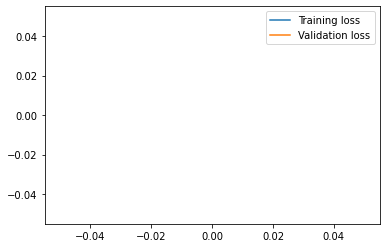

In [7]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



In [10]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=100  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)



[Timestamp('2021-09-10 00:00:00', freq='C'), Timestamp('2021-09-13 00:00:00', freq='C'), Timestamp('2021-09-14 00:00:00', freq='C'), Timestamp('2021-09-15 00:00:00', freq='C'), Timestamp('2021-09-16 00:00:00', freq='C'), Timestamp('2021-09-17 00:00:00', freq='C'), Timestamp('2021-09-20 00:00:00', freq='C'), Timestamp('2021-09-21 00:00:00', freq='C'), Timestamp('2021-09-22 00:00:00', freq='C'), Timestamp('2021-09-23 00:00:00', freq='C'), Timestamp('2021-09-24 00:00:00', freq='C'), Timestamp('2021-09-27 00:00:00', freq='C'), Timestamp('2021-09-28 00:00:00', freq='C'), Timestamp('2021-09-29 00:00:00', freq='C'), Timestamp('2021-09-30 00:00:00', freq='C'), Timestamp('2021-10-01 00:00:00', freq='C'), Timestamp('2021-10-04 00:00:00', freq='C'), Timestamp('2021-10-05 00:00:00', freq='C'), Timestamp('2021-10-06 00:00:00', freq='C'), Timestamp('2021-10-07 00:00:00', freq='C'), Timestamp('2021-10-08 00:00:00', freq='C'), Timestamp('2021-10-12 00:00:00', freq='C'), Timestamp('2021-10-13 00:00:00'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


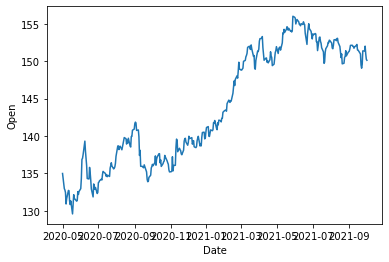

In [9]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])